In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, models
import torchvision.transforms as transforms
from datetime import datetime
from torch.utils import data
import random
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [50]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [51]:
#transform the images to the default input shape 224x224
transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])
data_set = datasets.ImageFolder(root = 'new_data', transform = transform, loader = default_loader)
n = len(data_set)
n_test = int( n * .2 )
n_train = n - n_test

In [52]:
# train, test split
train_set, test_set = data.random_split(data_set, (n_train, n_test))

In [53]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, num_workers=15)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, num_workers=15)

In [54]:
#Select 10 random images of each class.
path = 'new_data/'
num_files_per_folder = [len(files) for root, dirs, files in os.walk('new_data') if len(files) > 0]
folders = [dirs for root, dirs, files in os.walk('new_data') if len(dirs) > 0][0]
filenames = [os.listdir('new_data/' + folder) for folder in folders]
files = [np.random.choice(files, 10, replace = False) for files, num_files in zip(filenames, num_files_per_folder)]

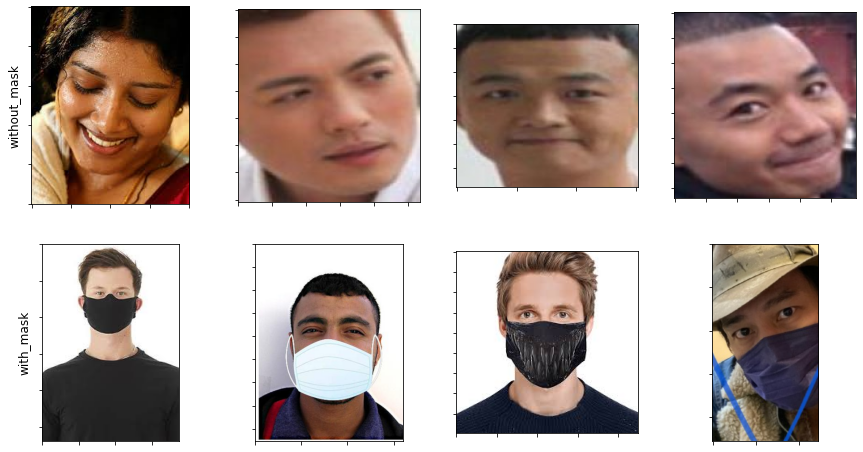

In [55]:
fig, ax = plt.subplots(2, 4, figsize = (15, 8))
for row in range(2):
    category = folders[row]
    ax_row = ax[row]
    for column in range(4):
        img = plt.imread(path + category + '/' + files[row][column])
        ax_column = ax_row[column]
        ax_column.imshow(img, cmap='gray')
        if column == 0:
            ax_column.set_ylabel(category, size = 'large')
        ax_column.set_xticklabels([])
        ax_column.set_yticklabels([])

In [56]:
#downloading the pretrained model
model = models.vgg16(weights = 'VGG16_Weights.DEFAULT')

In [57]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [58]:
n_inputs = model.classifier[6].in_features
classification_layer = nn.Linear(n_inputs, len(train_set.dataset.classes))
model.classifier[6] = classification_layer

In [59]:
n_inputs, len(train_set.dataset.classes)

(4096, 2)

In [60]:
for param in model.features.parameters():
    param.requires_grad = False

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [62]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')
model.to(device)

Device: cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [63]:
def training_loop(loader, epoch):
    
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()


        predicted = torch.argmax(F.softmax(outputs, dim = 1), dim = 1)
        
        
        equals = predicted == labels
        
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy

        if i %50 == 0:
            
            print(f'Epoch: {epoch+1} | loop {i+1}/{len(loader)} Loss: {loss.item():.5f} - Accuracy: {accuracy:.5f}')
        

    print(f'>>>>> Epoch: {epoch+1} Loss: {running_loss/len(loader):.5f} - Accuracy: {running_accuracy/len(loader):.5f}')

In [66]:
%%time 
for epoch in range(3):
    print('Training...')
    training_loop(train_loader, epoch)
    model.eval()
    print('Validation...')
    training_loop(test_loader, epoch)
    model.train()

Training...
Epoch: 1 | loop 1/48 Loss: 0.00094 - Accuracy: 1.00000
>>>>> Epoch: 1 Loss: 0.01634 - Accuracy: 0.99707
Validation...
Epoch: 1 | loop 1/12 Loss: 0.00009 - Accuracy: 1.00000
>>>>> Epoch: 1 Loss: 0.00402 - Accuracy: 0.99870
Training...
Epoch: 2 | loop 1/48 Loss: 0.00007 - Accuracy: 1.00000
>>>>> Epoch: 2 Loss: 0.01284 - Accuracy: 0.99788
Validation...
Epoch: 2 | loop 1/12 Loss: 0.01814 - Accuracy: 0.99219
>>>>> Epoch: 2 Loss: 0.00324 - Accuracy: 0.99870
Training...
Epoch: 3 | loop 1/48 Loss: 0.00000 - Accuracy: 1.00000
>>>>> Epoch: 3 Loss: 0.01113 - Accuracy: 0.99772
Validation...
Epoch: 3 | loop 1/12 Loss: 0.02807 - Accuracy: 0.99219
>>>>> Epoch: 3 Loss: 0.01045 - Accuracy: 0.99870
CPU times: user 49 s, sys: 3.5 s, total: 52.5 s
Wall time: 1min 42s


In [79]:
images, labels = next(iter(test_loader))
model.eval()
predicted = model(images.to(device)).cpu()
predicted = torch.argmax(F.softmax(predicted, dim = 1), dim = 1)
labels, predicted = labels.detach().numpy(), predicted.detach().numpy()

In [80]:
images = images.permute(0, 2, 3, 1).numpy()
images.shape

(128, 224, 224, 3)

In [81]:
idx_to_class = {k: v for v, k in test_set.dataset.class_to_idx.items()}
labels = [idx_to_class[label] for label in labels]
predicted = [idx_to_class[label] for label in predicted]

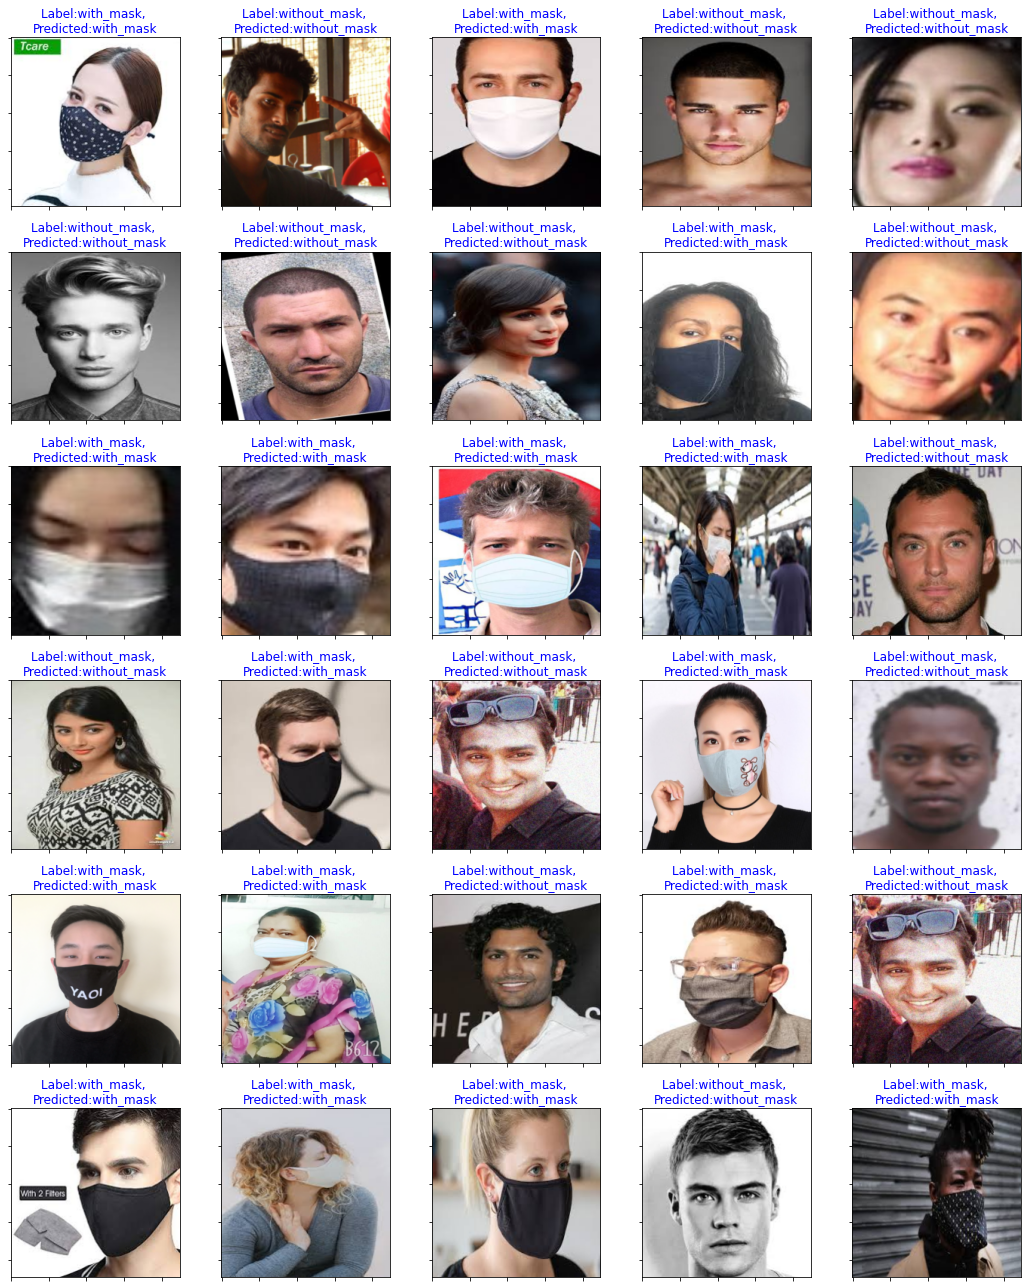

In [82]:
#Plotting the results.
fig, ax = plt.subplots(6, 5, figsize = (15, 18))
i = 0
for row in range(6):
    ax_row = ax[row]
    for column in range(5):
        ax_column = ax_row[column]
        ax_column.imshow(images[i])
        ax_column.set_xticklabels([])
        ax_column.set_yticklabels([])
        col = 'blue' if labels[i] == predicted[i] else 'red'
        ax_column.set_title(f'Label:{labels[i]}, \nPredicted:{predicted[i]}', color = col)
        i += 1 
        plt.tight_layout()

In [85]:
torch.save(model.state_dict(), 'mask_detection_model')

In [86]:
model_scripted = torch.jit.script(model)
model_scripted.save('mask_detection_model.pt')